<a href="https://colab.research.google.com/github/Yong-Zhuang/Tutoring/blob/main/Time_Series_Forecasting/CNN_for_Time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

refer to https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1

## Convolutional Neural Networks
Convolutional neural networks are deep artificial neural networks that are used primarily to classify images (e.g. name what they see), cluster them by similarity (photo search), and perform object recognition within scenes. They are algorithms that can identify faces, individuals, street signs, and many other aspects of visual data.


![alt text](https://cdn-images-1.medium.com/max/1600/1*Ji5QhY9QXBlpNNLH4qAcNA.png =780x)

## How Convolutional Neural Networks Work

### Convolutions

CNN’s make use of filters (also known as kernels), to detect what features, such as edges, are present throughout an image. A filter is just a matrix of values, called weights, that are trained to detect specific features. The filter moves over each part of the image to check if the feature it is meant to detect is present. To provide a value representing how confident it is that a specific feature is present, the filter carries out a convolution operation, which is an element-wise product and sum between two matrices.


![alt text](https://cdn-images-1.medium.com/max/1600/0*dRD6PhKOnnCIhz15.jpg =450x)


When the feature is present in part of an image, the convolution operation between the filter and that part of the image results in a real number with a high value. If the feature is not present, the resulting value is low.

In the following example, a filter that is in charge of checking for right-hand curves is passed over a part of the image. Since that part of the image contains the same curve that the filter is looking for, the result of the convolution operation is a large number (6600).

![alt text](https://cdn-images-1.medium.com/max/1600/1*rrqwVqUBLgyK6PFWqSI7lA.png =650x)

But when that same filter is passed over a part of the image with a considerably different set of edges, the convolution’s output is small, meaning that there was no strong presence of a right hand curve.

![alt text](https://cdn-images-1.medium.com/max/1600/1*ev0jRDBf0JwPS8C3VuYGHg.png =650x)

The result of passing this filter over the entire image is an output matrix that stores the convolutions of this filter over various parts of the image. The filter must have the same number of channels as the input image so that the element-wise multiplication can take place. For instance, if the input image contains three channels (RGB, for example), then the filter must contain three channels as well.

The convolution of a filter over a 2D image:

![alt text](http://deeplearning.net/software/theano/_images/numerical_no_padding_no_strides.gif =350x)

The light blue grid is called the input feature map. A kernel (filter) of value

\begin{pmatrix}
0 & 1 & 2 \\
2 & 2 & 0 \\
0 & 1 & 2
\end{pmatrix}

Additionally, a filter can be slid over the input image at varying intervals, using a stride value. The stride value dictates by how much the filter should move at each step. The output dimensions of a strided convolution can be calculated using the following equation:

Accepts a volume of size $W_1×H_1×D_1$
Requires four hyperparameters:
1. Number of filters $K$,
2. their spatial extent $F$,
3. the stride $S$,
4. the amount of zero padding $P$.

Produces a volume of size $W_2×H_2×D_2$ where:
1. $W_2=\left\lfloor \frac{W_1 + 2P - F}{s} \right\rfloor + 1$
2. $H_2=\left\lfloor \frac{H_1 + 2P - F}{s} \right\rfloor + 1$ 
3. $D_2=K$

For instance, here is a $3 \times 3$ kernel applied to a $5 \times 5$ input padded with a $1 \times 1$ border of zeros using $2 \times 2$ strides

![alt text](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif =380x)

### General pooling
2D average pooling and max pooling, used in CNNs to spatially downsample image tensors.

![alt text](http://cs231n.github.io/assets/cnn/pool.jpeg =300x)    ![alt text](http://cs231n.github.io/assets/cnn/maxpool.jpeg =550x)

## 1D Convolutional Neural Networks

1D convolutional neural networks can be competitive with RNNs on certain sequence-processing problems, usually at a considerably cheaper computational cost. Recently, 1D convolutional neural networks, typically used with dilated kernels, have been used with great success for audio generation and machine translation. In addition to these specific successes, it has long been known that small 1D convolutional neural networks can offer a fast alternative to RNNs for timeseries forecasting.

## How 1D convolution works: 
Each output timestep is obtained from a temporal patch in the input sequence.


![alt text](https://cdn-images-1.medium.com/max/800/0*qJC2UjY0CwaGdRbD.jpg =350x)

Such 1D convolution layers can recognize local patterns in a sequence. Because the same input transformation is performed on every patch, a pattern learned at a certain time step in a time series can later be recognized at a different time step, making 1D CNNs translation invariant (for temporal translations). 

### Pooling

Extract 1D patches (subsequences) from an input and outputting the maximum value (max pooling) or average value (average pooling). Just as with 2D CNNs, this is used for reducing the length of 1D inputs (subsampling).

## Sample Code

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'
rcParams["legend.loc"] = 'upper left'

Using TensorFlow backend.


## Loading and Handling Time Series in Pandas

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


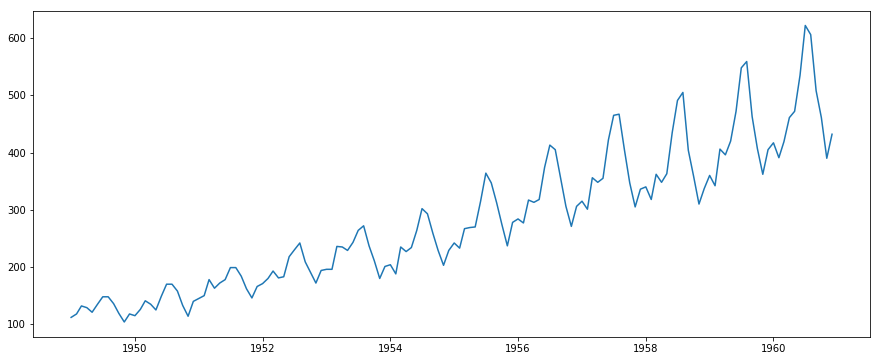

In [ ]:
url = 'https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv'
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data = data.astype('float64')
plt.plot(data)

## Split a sequence into samples

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence.iloc[i:end_ix].values, sequence.iloc[end_ix].values
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
n_steps = 5
X, y = split_sequence(data, n_steps)
print ('(samples, timesteps, features): '+ str(X.shape))

(samples, timesteps, features): (139, 5, 1)


### Split Dataset
We can split the dataset into three parts.

The first part is the training dataset that we will use to train our model. The second part is the validation part that we will use it to validate the perfromance of our model. The third part is the test dataset that we will pretend is not available. It is these time steps that we will treat as out of sample.

The dataset contains data from January 1949 to December 1960.

1. 1949 - 1957:**Training**
2. 1958: **Validation**
3. 1959 - 1960: **Test**

In [ ]:
X_train, y_train = X[:-36],y[:-36]
X_valid, y_valid = X[-36:-24],y[-36:-24]
X_test, y_test = X[-24:],y[-24:]
print (X_train.shape,X_valid.shape,X_test.shape)

(103, 5, 1) (12, 5, 1) (24, 5, 1)


## Build a CNN model

In [ ]:
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(1))
cnn.compile(optimizer='adam', loss='mse')
cnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 6,693
Trainable params: 6,693
Non-trainable params: 0
_________________________________________________________________


## Train model and demonstrate prediction

In [ ]:
cnn.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=200, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 103 samples, validate on 12 samples
Epoch 1/200
103/103 [==============================] - 1s 7ms/step - loss: 59004.3949 - val_loss: 115860.7188
Epoch 2/200
103/103 [==============================] - 0s 112us/step - loss: 44773.3451 - val_loss: 84947.4297
Epoch 3/200
103/103 [==============================] - 0s 112us/step - loss: 32949.5820 - val_loss: 60753.8320
Epoch 4/200
103/103 [==============================] - 0s 91us/step - loss: 23439.9539 - val_loss: 41152.1602
Epoch 5/200
103/103 [==============================] - 0s 94us/step - loss: 15822.9867 - val_loss: 25263.8594
Epoch 6/200
103/103 [==============================] - 0s 122us/step - loss: 9342.7104 - val_loss: 13686.5469
Epoch 7/200
103/103 [==============================] - 0s 103us/step - loss: 4654.7969 - val_loss: 7354.8730
Epoch 8/200
103/103 [==============================] - 0s 122us/step - loss: 2398.7745 - val_loss: 6147.1367
Epoch 9/200
103/103 [======

In [ ]:
# make predictions
predict = cnn.predict(X_test)
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_test, predict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 51.08 RMSE


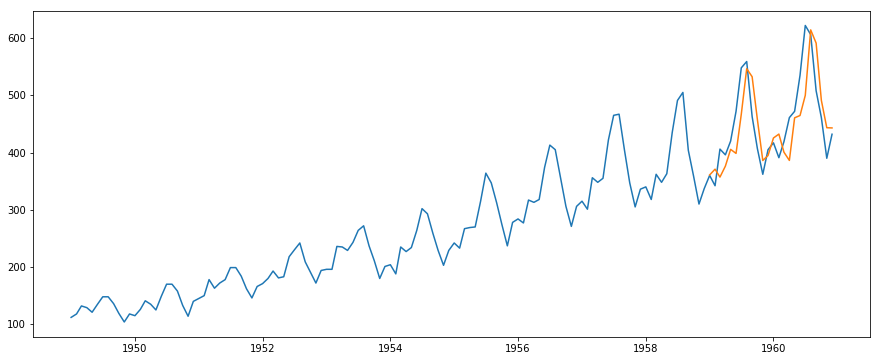

In [ ]:

predict_plot = pd.DataFrame(predict,index=data.index[-24:])
plt.plot(data)
plt.plot(predict_plot)
plt.show()